In [1]:
#@title Install + Imports

import os, json, warnings, zipfile
from pathlib import Path
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# imbalance tools
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import plotly.graph_objects as go
import plotly.express as px
from google.colab import files

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_columns", 200)


In [2]:
#@title Import Dataset
from google.colab import drive
drive.mount('/content/drive')

# 🔁 Use the shared drive name and folder structure
SHARED_DRIVE = "CMPE_279_Anamoly_Detection"
PROJECT_DIR  = "Project"

# 🔧 Set main directory path
DRIVE_DIR = f"/content/drive/MyDrive/{SHARED_DRIVE}/{PROJECT_DIR}"

# 📂 Define dataset paths
RAW_CSV        = f"{DRIVE_DIR}/ACI-IoT-2023.csv"

DATA_DIR = "/content/preprocessed_iot"
OUT_DIR  = Path(DATA_DIR); OUT_DIR.mkdir(parents=True, exist_ok=True)

# ✅ Ensure folder exists
import os
os.makedirs(DRIVE_DIR, exist_ok=True)
print("Using folder:", DRIVE_DIR)

Mounted at /content/drive
Using folder: /content/drive/MyDrive/CMPE_279_Anamoly_Detection/Project


In [3]:
# Core column names
LABEL_COL = "Label"   # <-- change if needed

# Splits & reproducibility
TEST_SIZE     = 0.20
VAL_SIZE      = 0.20
RANDOM_STATE  = 42
TRAIN_BALANCE = "oversample"  # "oversample" | "undersample" | "none"
INPUT_CSV = RAW_CSV


In [4]:
# ==== TURBO MODE (fast & memory-safe) ====
FAST_MODE = True          # turn off later for full runs
ROW_CAP_TRAIN_PER_CLASS = 5000   # cap rows/class for TRAIN
ROW_CAP_VAL_TEST_PER_CLASS = 2000
MAX_CATS_PER_COL = 100    # bucket rare categories
DTYPE_FLOAT = "float32"   # reduce RAM vs float64

# FT-Transformer (lighter)
FTT_D_TOKEN        = 16   # was 32
FTT_N_BLOCKS       = 2    # was 3
FTT_N_HEADS        = 2    # was 4
FTT_MAX_EPOCHS     = 15   # was 40
FTT_PATIENCE       = 3    # was 6
FTT_BATCH_SIZE     = 512  # was 1024

# MLP (smaller)
MLP_HIDDEN1        = 256  # was 512
MLP_HIDDEN2        = 128  # was 256
MLP_DROPOUT        = 0.15
MLP_MAX_EPOCHS     = 20   # was 40
MLP_PATIENCE       = 5
MLP_BATCH_SIZE     = 512  # was 1024

# LightGBM (fewer trees)
LGBM_NUM_BOOST_ROUND  = 800   # was 5000
LGBM_EARLY_STOP_ROUND = 100

# General
NUM_WORKERS = 0  # keep 0 in Colab to avoid dataloader & fork overhead


In [5]:
from pathlib import Path
ARTIFACTS_DIR = Path("/content/artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
print("Artifacts dir:", ARTIFACTS_DIR)


Artifacts dir: /content/artifacts


In [6]:
#@title 🧹 Preprocess → split → balance → save (GPU-aware, fast & safe)

# ==== knobs ====
USE_GPU = True                 # 👈 turn on to scale numerics on GPU (if CUDA is available)
SKIP_PLOTS_IN_FAST = True      # skip plotly .show() when FAST_MODE to save time/memory

import gc
import torch

def clean_dataframe(df: pd.DataFrame, label_col: str) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    if label_col not in df.columns:
        raise ValueError(f"Label column '{label_col}' not found. Found: {df.columns.tolist()}")
    df = df.replace([np.inf, -np.inf], np.nan)
    nunique = df.nunique(dropna=False)
    drop_cols = nunique[nunique <= 1].index.tolist()
    if drop_cols:
        df = df.drop(columns=drop_cols)
    # fast NA fill
    for c in df.columns:
        if c == label_col:
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            df[c] = df[c].fillna(df[c].median())
        else:
            df[c] = df[c].astype(str).fillna("Unknown")
    return df

def detect_categoricals(df: pd.DataFrame, label_col: str, provided: Optional[List[str]]=None) -> List[str]:
    if provided:
        return [c for c in provided if c in df.columns and c != label_col]
    cats = []
    # object dtypes and small-cardinality ints → treated as categorical
    for c in df.columns:
        if c == label_col:
            continue
        if df[c].dtype == object:
            cats.append(c)
        else:
            if df[c].dtype.kind in "iu" and 2 <= df[c].nunique(dropna=True) <= 20:
                cats.append(c)
    return sorted(list(set(cats)))

def stratified_splits(df, label_col, test_size, val_size, seed):
    y = df[label_col]
    train_df, test_df = train_test_split(df, test_size=test_size, stratify=y, random_state=seed)
    y_tr = train_df[label_col]
    train_df, val_df = train_test_split(train_df, test_size=val_size, stratify=y_tr, random_state=seed)
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

def balance_train(train_df: pd.DataFrame, label_col: str, strategy: str, seed: int) -> pd.DataFrame:
    if strategy not in {"oversample","undersample","none"}:
        strategy = "none"
    if strategy == "none":
        return train_df
    rng = np.random.default_rng(seed)
    groups = {k: g for k, g in train_df.groupby(label_col)}
    sizes  = {k: len(v) for k, v in groups.items()}
    if strategy == "oversample":
        target = max(sizes.values()); parts=[]
        for k,g in groups.items():
            if len(g) < target:
                idx = rng.choice(g.index.to_numpy(), size=target-len(g), replace=True)
                parts.append(pd.concat([g, train_df.loc[idx]], axis=0))
            else:
                parts.append(g)
        return pd.concat(parts).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    else:
        target = min(sizes.values())
        parts = [g.sample(n=target, random_state=seed) for g in groups.values()]
        return pd.concat(parts).sample(frac=1.0, random_state=seed).reset_index(drop=True)

def plot_class_bar(counts: pd.Series, title: str, out_html: Path):
    fig = go.Figure(go.Bar(x=counts.index.astype(str), y=counts.values))
    fig.update_layout(title=title, xaxis_title="Class", yaxis_title="Count", template="plotly_white")
    # avoid interactive render in FAST_MODE to reduce crashes
    if not (FAST_MODE and SKIP_PLOTS_IN_FAST):
        fig.show()
    fig.write_html(str(out_html), include_plotlyjs="cdn")

def plot_numeric_heatmap(df: pd.DataFrame, title: str, out_html: Path):
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != LABEL_COL]
    if len(num_cols) < 2:
        return
    corr = df[num_cols].corr(method="spearman")
    fig = px.imshow(corr, color_continuous_scale="RdBu_r", origin="lower", title=title)
    fig.update_layout(template="plotly_white")
    if not (FAST_MODE and SKIP_PLOTS_IN_FAST):
        fig.show()
    fig.write_html(str(out_html), include_plotlyjs="cdn")

# 1) Load & clean
df = pd.read_csv(INPUT_CSV)
df = clean_dataframe(df, LABEL_COL)

# 2) Detect cats/nums
cat_cols = detect_categoricals(df, LABEL_COL, provided=None)
num_cols = [c for c in df.columns if c not in cat_cols + [LABEL_COL]]

# Downcast numerics to float32 / int32 to save RAM
for c in df.columns:
    if c == LABEL_COL:
        continue
    if pd.api.types.is_float_dtype(df[c]):
        df[c] = df[c].astype(DTYPE_FLOAT)
    elif pd.api.types.is_integer_dtype(df[c]):
        if df[c].min() >= np.iinfo(np.int32).min and df[c].max() <= np.iinfo(np.int32).max:
            df[c] = df[c].astype("int32")

# Bucket rare categories to keep one-hot small
def bucket_rare_cats(frame, cols, max_cats=MAX_CATS_PER_COL):
    for c in cols:
        if c not in frame.columns:
            continue
        vc = frame[c].value_counts(sort=True, dropna=False)
        if len(vc) > max_cats:
            keep = set(vc.head(max_cats).index)
            frame[c] = frame[c].where(frame[c].isin(keep), other="__OTHER__")
    return frame

df[cat_cols] = df[cat_cols].astype(str)
if FAST_MODE:
    df = bucket_rare_cats(df, cat_cols, MAX_CATS_PER_COL)

# 3) Split
train_df, val_df, test_df = stratified_splits(df, LABEL_COL, TEST_SIZE, VAL_SIZE, RANDOM_STATE)

# Stratified caps per class to reduce size safely (for fast runs)
def strat_cap_per_class(frame, per_class, label_col):
    parts = []
    for y, g in frame.groupby(label_col):
        if len(g) > per_class:
            parts.append(g.sample(per_class, random_state=RANDOM_STATE))
        else:
            parts.append(g)
    out = pd.concat(parts).sample(frac=1.0, random_state=RANDOM_STATE)
    return out

if FAST_MODE:
    train_df = strat_cap_per_class(train_df, ROW_CAP_TRAIN_PER_CLASS, LABEL_COL)
    val_df   = strat_cap_per_class(val_df, ROW_CAP_VAL_TEST_PER_CLASS, LABEL_COL)
    test_df  = strat_cap_per_class(test_df, ROW_CAP_VAL_TEST_PER_CLASS, LABEL_COL)

# 4) Plots (before/after balance)
plot_class_bar(train_df[LABEL_COL].value_counts().sort_index(),
               "Train Class Distribution (Before Balance)", OUT_DIR/"train_before.html")
train_bal = balance_train(train_df, LABEL_COL, TRAIN_BALANCE, RANDOM_STATE)
plot_class_bar(train_bal[LABEL_COL].value_counts().sort_index(),
               "Train Class Distribution (After Balance)", OUT_DIR/"train_after.html")

# 5) optional numeric heatmaps
plot_numeric_heatmap(train_df, "Spearman Correlation — Train (Before Balance)", OUT_DIR/"corr_before.html")
plot_numeric_heatmap(train_bal, "Spearman Correlation — Train (After Balance)", OUT_DIR/"corr_after.html")

# 6) Scale numerics (GPU if available & requested)
def scale_on_gpu(train_df, val_df, test_df, num_cols):
    """Standardize numeric columns using torch on CUDA, then return CPU DataFrames."""
    if not num_cols:
        return train_df, val_df, test_df, None
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type != "cuda":
        return scale_on_cpu(train_df, val_df, test_df, num_cols)  # fallback

    # to GPU
    t_train = torch.tensor(train_df[num_cols].to_numpy(), dtype=torch.float32, device=device)
    mean = t_train.mean(dim=0, keepdim=True)
    std  = t_train.std(dim=0, unbiased=False, keepdim=True).clamp_min(1e-8)

    def _transform(df_part):
        t = torch.tensor(df_part[num_cols].to_numpy(), dtype=torch.float32, device=device)
        t = (t - mean) / std
        return pd.DataFrame(t.cpu().numpy().astype("float32"), columns=num_cols, index=df_part.index)

    # transform and assign back (in-place assignment avoids large copies)
    train_scaled = _transform(train_df)
    val_scaled   = _transform(val_df)
    test_scaled  = _transform(test_df)

    for c in num_cols:
        train_df[c] = train_scaled[c].astype(DTYPE_FLOAT)
        val_df[c]   = val_scaled[c].astype(DTYPE_FLOAT)
        test_df[c]  = test_scaled[c].astype(DTYPE_FLOAT)

    # save stats for later reuse (mimic sklearn StandardScaler)
    scaler_state = {"mean_": mean.squeeze(0).cpu().numpy(), "scale_": std.squeeze(0).cpu().numpy(), "num_cols": num_cols}
    return train_df, val_df, test_df, scaler_state

def scale_on_cpu(train_df, val_df, test_df, num_cols):
    if not num_cols:
        return train_df, val_df, test_df, None
    scaler = StandardScaler()
    scaler.fit(train_df[num_cols])
    train_df[num_cols] = scaler.transform(train_df[num_cols]).astype(DTYPE_FLOAT)
    val_df[num_cols]   = scaler.transform(val_df[num_cols]).astype(DTYPE_FLOAT)
    test_df[num_cols]  = scaler.transform(test_df[num_cols]).astype(DTYPE_FLOAT)
    return train_df, val_df, test_df, {"sklearn": True, "scaler": scaler, "num_cols": num_cols}

if USE_GPU and torch.cuda.is_available():
    train_bal, val_df, test_df, scaler_bundle_state = scale_on_gpu(train_bal, val_df, test_df, num_cols)
else:
    train_bal, val_df, test_df, scaler_bundle_state = scale_on_cpu(train_bal, val_df, test_df, num_cols)

# 7) Ensure categoricals are strings
for c in cat_cols + [LABEL_COL]:
    for split in (train_bal, val_df, test_df):
        if c in split.columns:
            split[c] = split[c].astype(str)

# 8) Save canonical splits for tabular DL/MLP
train_bal.to_csv(OUT_DIR/"ftt_train.csv", index=False)
val_df.to_csv(OUT_DIR/"ftt_val.csv", index=False)
test_df.to_csv(OUT_DIR/"ftt_test.csv", index=False)

# build a unified scaler bundle (works for GPU or CPU path)
if scaler_bundle_state and scaler_bundle_state.get("sklearn"):
    # sklearn scaler object
    joblib.dump({"num_cols": num_cols, "cat_cols": cat_cols, "scaler": scaler_bundle_state["scaler"]}, OUT_DIR/"ftt_scaler.joblib")
else:
    # torch-computed mean/std; keep simple dict (you can load and use manually later)
    joblib.dump({"num_cols": num_cols, "cat_cols": cat_cols, "mean_": (scaler_bundle_state or {}).get("mean_"),
                 "scale_": (scaler_bundle_state or {}).get("scale_"), "scaler": None}, OUT_DIR/"ftt_scaler.joblib")

# 9) Label mapping (for reports)
cats = pd.Categorical(df[LABEL_COL])
label_map = {str(cat): int(code) for code, cat in enumerate(cats.categories)}
(OUT_DIR/"label_mapping.json").write_text(json.dumps(label_map, indent=2))

# Free memory
del df; gc.collect()

print("Saved to:", OUT_DIR)
print("Categoricals:", cat_cols[:10], "… total", len(cat_cols))
print("Numerics:", num_cols[:10], "… total", len(num_cols))
print("Scaling:", "GPU (torch)" if (USE_GPU and torch.cuda.is_available()) else "CPU (sklearn)")

Saved to: /content/preprocessed_iot
Categoricals: ['CWR Flag Count', 'Connection Type', 'Dst IP', 'ECE Flag Count', 'FIN Flag Count', 'Flow ID', 'Fwd PSH Flags', 'Fwd Seg Size Min', 'Fwd URG Flags', 'Protocol'] … total 16
Numerics: ['Src Port', 'Dst Port', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean'] … total 62
Scaling: GPU (torch)


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49592 entries, 576148 to 1336
Data columns (total 79 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Flow ID                     49592 non-null  object 
 1   Src IP                      49592 non-null  object 
 2   Src Port                    49592 non-null  int32  
 3   Dst IP                      49592 non-null  object 
 4   Dst Port                    49592 non-null  int32  
 5   Protocol                    49592 non-null  object 
 6   Timestamp                   49592 non-null  object 
 7   Flow Duration               49592 non-null  int32  
 8   Total Fwd Packet            49592 non-null  int32  
 9   Total Bwd packets           49592 non-null  int32  
 10  Total Length of Fwd Packet  49592 non-null  float32
 11  Total Length of Bwd Packet  49592 non-null  float32
 12  Fwd Packet Length Max       49592 non-null  float32
 13  Fwd Packet Length Min       4959

In [8]:
# ================== MINIMAL, HIGH-VALUE PLOTTING ==================
from pathlib import Path
import re, gc
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.feature_selection import mutual_info_classif

# ---- Colab renderer
try: pio.renderers.default = "colab"
except Exception: pio.renderers.default = "notebook_connected"

# ---- Config (tweak if needed)
PLOT_SAMPLE_MAX      = 20000   # sample rows for speed
TOP_NUMERIC_K        = 4       # how many numeric features to show (boxplots)
TOP_CATEGORICAL_K    = 4       # how many categorical features to show (bars)
PLOT_CATEGORICAL_TOP = 15      # top levels per categorical column

# ---- Ensure OUT_DIR exists
OUT_DIR = Path(OUT_DIR); OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- Helpers
def safe_name(s: str, maxlen: int = 90) -> str:
    s = str(s)
    s = re.sub(r'[^A-Za-z0-9._-]+', '_', s)
    s = re.sub(r'_{2,}', '_', s).strip('._-')
    return (s[:maxlen].rstrip('._-')) or "plot"

def _maybe_sample(df: pd.DataFrame, max_n: int) -> pd.DataFrame:
    return df if len(df) <= max_n else df.sample(n=max_n, random_state=RANDOM_STATE)

def _save_and_show(fig, filename: str):
    out = OUT_DIR / safe_name(filename)
    fig.write_html(str(out), include_plotlyjs="cdn")
    fig.show()

def _ensure_splits():
    g = globals()
    if ("train_df" in g) and ("train_bal" in g):
        tr, tr_bal = g["train_df"], g["train_bal"]
        return tr, tr_bal
    tr_bal = pd.read_csv(OUT_DIR/"ftt_train.csv")
    # If the unbalanced train isn't kept, use balanced as proxy for the "before" bar
    tr = tr_bal.copy()
    return tr, tr_bal

def _detect_types(df: pd.DataFrame, label_col: str):
    cat_cols, num_cols = [], []
    for c in df.columns:
        if c == label_col:
            continue
        if df[c].dtype == object:
            cat_cols.append(c)
        elif pd.api.types.is_numeric_dtype(df[c]):
            num_cols.append(c)
        else:
            # low-card ints → categorical
            if df[c].dtype.kind in "iu" and df[c].nunique(dropna=True) <= 20:
                cat_cols.append(c)
    return cat_cols, num_cols

def _mutual_info_ranking(df: pd.DataFrame, label_col: str, cat_cols, num_cols, k_num=4, k_cat=4):
    """Rank columns by mutual information with the label. Returns top lists."""
    # sample for speed
    df_s = _maybe_sample(df[cat_cols + num_cols + [label_col]].copy(), PLOT_SAMPLE_MAX)
    y = pd.Categorical(df_s[label_col]).codes

    # Numeric MI
    numeric_scores = []
    for c in num_cols:
        x = df_s[[c]].to_numpy(dtype=np.float32)
        # discrete_features=False
        mi = mutual_info_classif(x, y, discrete_features=False, random_state=RANDOM_STATE)
        numeric_scores.append((c, float(mi[0])))
    top_num = [c for c,_ in sorted(numeric_scores, key=lambda t: t[1], reverse=True)[:k_num]]

    # Categorical MI
    categorical_scores = []
    for c in cat_cols:
        # encode categories to integers; mutual_info_classif will treat as discrete
        x = pd.Categorical(df_s[c].astype(str)).codes.reshape(-1,1)
        mi = mutual_info_classif(x, y, discrete_features=True, random_state=RANDOM_STATE)
        categorical_scores.append((c, float(mi[0])))
    top_cat = [c for c,_ in sorted(categorical_scores, key=lambda t: t[1], reverse=True)[:k_cat]]

    return top_num, top_cat, numeric_scores, categorical_scores

# ---- Minimal plots
def plot_class_bars(tr_before: pd.DataFrame, tr_after: pd.DataFrame):
    for frame, tag, title in [
        (tr_before, "before", "Train Class Distribution (Before Balance)"),
        (tr_after,  "after",  "Train Class Distribution (After Balance)"),
    ]:
        counts = frame[LABEL_COL].value_counts().sort_index()
        fig = go.Figure(go.Bar(x=counts.index.astype(str), y=counts.values))
        fig.update_layout(title=title, xaxis_title="Class", yaxis_title="Count", template="plotly_white")
        _save_and_show(fig, f"train_class_{tag}.html")

def plot_one_heatmap(tr_after: pd.DataFrame):
    # Only AFTER balance (cleaner view)
    cat_cols, num_cols = _detect_types(tr_after, LABEL_COL)
    if len(num_cols) < 2:
        return
    df_s = _maybe_sample(tr_after[num_cols], PLOT_SAMPLE_MAX)
    corr = df_s.corr(method="spearman")
    fig = px.imshow(corr, color_continuous_scale="RdBu_r", origin="lower",
                    title="Spearman Correlation — Train (After Balance)")
    fig.update_layout(template="plotly_white")
    _save_and_show(fig, "corr_after.html")

def plot_top_numeric_boxplots(tr_after: pd.DataFrame, top_num_cols):
    if not top_num_cols:
        return
    df_s = _maybe_sample(tr_after[top_num_cols + [LABEL_COL]], PLOT_SAMPLE_MAX)
    for col in top_num_cols:
        fig = px.box(df_s, x=LABEL_COL, y=col, points="outliers",
                     title=f"Boxplot — {col} by {LABEL_COL}")
        fig.update_layout(template="plotly_white")
        _save_and_show(fig, f"box_after_{safe_name(col)}.html")

def plot_top_categorical_bars(tr_after: pd.DataFrame, top_cat_cols):
    if not top_cat_cols:
        return
    df_s_all = _maybe_sample(tr_after[top_cat_cols + [LABEL_COL]], PLOT_SAMPLE_MAX)
    for c in top_cat_cols:
        df_s = df_s_all[[c, LABEL_COL]].copy()
        vc = df_s[c].value_counts().head(PLOT_CATEGORICAL_TOP)
        df_plot = df_s[df_s[c].isin(vc.index)]
        fig = px.histogram(df_plot, x=c, color=LABEL_COL, barmode="group",
                           title=f"Categorical Levels — {c} by {LABEL_COL}")
        fig.update_layout(template="plotly_white", xaxis={'categoryorder':'total descending'})
        _save_and_show(fig, f"catbar_after_{safe_name(c)}.html")

# ---- Run everything (minimal)
def make_minimal_plots():
    tr, tr_bal = _ensure_splits()
    tr[LABEL_COL] = tr[LABEL_COL].astype(str)
    tr_bal[LABEL_COL] = tr_bal[LABEL_COL].astype(str)

    # 1) Class distributions
    plot_class_bars(tr, tr_bal)

    # Detect types on balanced train
    cat_cols, num_cols = _detect_types(tr_bal, LABEL_COL)

    # 2) Rank features by MI on balanced train; select top-K
    top_num, top_cat, num_scores, cat_scores = _mutual_info_ranking(
        tr_bal, LABEL_COL, cat_cols, num_cols, k_num=TOP_NUMERIC_K, k_cat=TOP_CATEGORICAL_K
    )
    # Optional: print the ranked lists (uncomment if you want to see them)
    # print("Top numeric by MI:", top_num)
    # print("Top categorical by MI:", top_cat)

    # 3) One heatmap (after balance)
    plot_one_heatmap(tr_bal)

    # 4) Boxplots for top-K numeric (after balance)
    plot_top_numeric_boxplots(tr_bal, top_num)

    # 5) Bars for top-K categorical (after balance)
    plot_top_categorical_bars(tr_bal, top_cat)

    gc.collect()
    made = sorted(str(p.name) for p in OUT_DIR.glob("*.html"))
    print(f"saved to {OUT_DIR} ({len(made)} files)")
    print("Examples:", made[:10])

make_minimal_plots()


saved to /content/preprocessed_iot (14 files)
Examples: ['box_after_Idle_Max.html', 'box_after_Idle_Mean.html', 'box_after_Idle_Min.html', 'box_after_Src_Port.html', 'catbar_after_Dst_IP.html', 'catbar_after_Fwd_Seg_Size_Min.html', 'catbar_after_SYN_Flag_Count.html', 'catbar_after_Src_IP.html', 'corr_after.html', 'corr_before.html']


Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.000902071	train's multi_error: 0.000116667	val's multi_logloss: 0.00255272	val's multi_error: 0.000417776
[200]	train's multi_logloss: 0.00011899	train's multi_error: 0	val's multi_logloss: 0.00170256	val's multi_error: 0.000417776
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.000302247	train's multi_error: 0	val's multi_logloss: 0.00192959	val's multi_error: 0.000365554
[LGBM] Acc=0.9995 | Macro-F1=0.9989
                    precision    recall  f1-score   support

      ARP Spoofing       1.00      1.00      1.00         1
            Benign       1.00      1.00      1.00      2000
         DNS Flood       1.00      1.00      1.00      2000
 Dictionary Attack       1.00      1.00      1.00      1276
        ICMP Flood       1.00      1.00      1.00      2000
           OS Scan       1.00      1.00      1.00      2000
        Ping Sweep       1.00      1.00      1.00      2

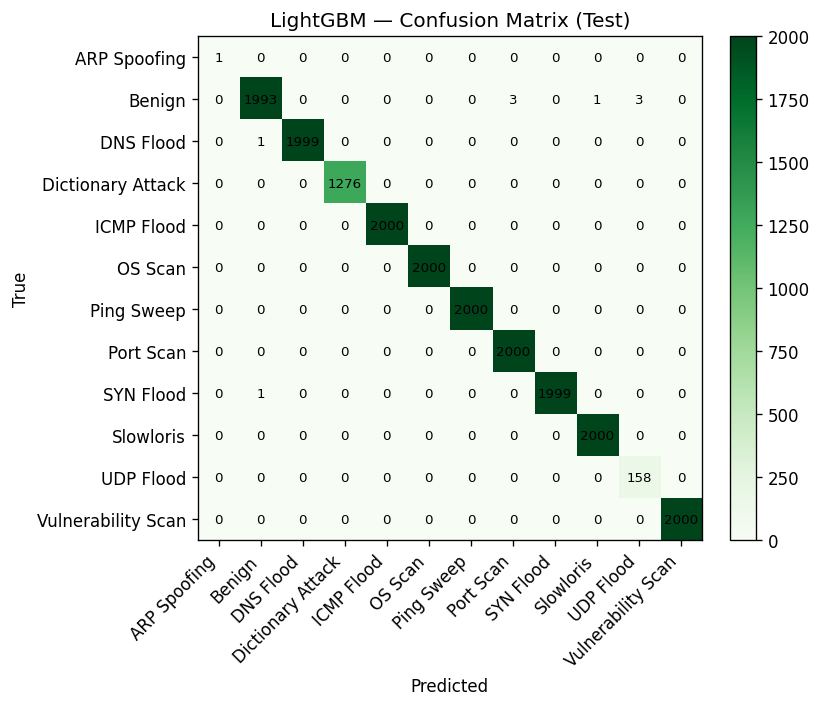

Saved: /content/artifacts/lgbm_model.txt /content/artifacts/ohe.joblib /content/artifacts/classes.json /content/artifacts/lgbm_confusion_matrix.png


In [9]:
#@title 🧠 LightGBM — train, evaluate, save
import json, gc, numpy as np, pandas as pd, joblib, lightgbm as lgb
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# --- Load splits ---
train = pd.read_csv(OUT_DIR/"ftt_train.csv")
val   = pd.read_csv(OUT_DIR/"ftt_val.csv")
test  = pd.read_csv(OUT_DIR/"ftt_test.csv")

# --- Columns & labels ---
bundle   = joblib.load(OUT_DIR/"ftt_scaler.joblib")
CAT_COLS = bundle["cat_cols"] or []
NUM_COLS = bundle["num_cols"] or []
classes  = sorted(train[LABEL_COL].astype(str).unique().tolist())
lab2id   = {c:i for i,c in enumerate(classes)}

ytr = train[LABEL_COL].astype(str).map(lab2id).to_numpy()
yva = val[LABEL_COL].astype(str).map(lab2id).to_numpy()
yte = test[LABEL_COL].astype(str).map(lab2id).to_numpy()

# --- One-hot + passthrough numerics ---
try:
    ohe = ColumnTransformer([
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32), CAT_COLS),
        ("pass","passthrough", NUM_COLS),
    ])
except TypeError:  # older sklearn
    ohe = ColumnTransformer([
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False, dtype=np.float32), CAT_COLS),
        ("pass","passthrough", NUM_COLS),
    ])

Xtr = ohe.fit_transform(train[CAT_COLS+NUM_COLS])
Xva = ohe.transform(val[CAT_COLS+NUM_COLS])
Xte = ohe.transform(test[CAT_COLS+NUM_COLS])

# --- Train ---
lgb_tr = lgb.Dataset(Xtr, label=ytr)
lgb_va = lgb.Dataset(Xva, label=yva, reference=lgb_tr)

params = dict(
    objective="multiclass",
    num_class=len(classes),
    boosting_type="gbdt",
    learning_rate=0.05,
    num_leaves=48,
    min_data_in_leaf=64,
    feature_fraction=0.85,
    bagging_fraction=0.85,
    bagging_freq=1,
    lambda_l2=1.0,
    max_bin=255,
    metric=["multi_logloss","multi_error"],
    seed=RANDOM_STATE,
    n_jobs=-1,
    verbosity=-1,
)

callbacks = [lgb.early_stopping(100, verbose=True), lgb.log_evaluation(100)]
lgbm = lgb.train(
    params,
    lgb_tr,
    valid_sets=[lgb_tr, lgb_va],
    valid_names=["train","val"],
    num_boost_round=1200,
    callbacks=callbacks
)

# --- Predict & metrics ---
proba  = lgbm.predict(Xte, num_iteration=lgbm.best_iteration)
y_pred = proba.argmax(1)

acc = accuracy_score(yte, y_pred)
mf1 = f1_score(yte, y_pred, average="macro")
print(f"[LGBM] Acc={acc:.4f} | Macro-F1={mf1:.4f}")
print(classification_report(yte, y_pred, target_names=classes, zero_division=0))

# --- Confusion matrices (counts + normalized) ---
cm = confusion_matrix(yte, y_pred, labels=range(len(classes)))
cm_norm = cm.astype(np.float64) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)

# --- Save artifacts ---
ARTIFACTS_DIR.mkdir(exist_ok=True, parents=True)
lgbm.save_model(str(ARTIFACTS_DIR/"lgbm_model.txt"), num_iteration=lgbm.best_iteration)
joblib.dump(ohe, ARTIFACTS_DIR/"ohe.joblib")
(ARTIFACTS_DIR/"classes.json").write_text(json.dumps(classes, indent=2))

# Save confusion matrices
pd.DataFrame(cm, index=classes, columns=classes).to_csv(ARTIFACTS_DIR/"lgbm_confusion_matrix.csv")
pd.DataFrame(cm_norm, index=classes, columns=classes).to_csv(ARTIFACTS_DIR/"lgbm_confusion_matrix_normalized.csv")

# Plot & save PNG (counts)
fig, ax = plt.subplots(figsize=(7.5, 6.0), dpi=120)
im = ax.imshow(cm, cmap="Greens")
ax.set_title("LightGBM — Confusion Matrix (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right"); ax.set_yticklabels(classes)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=8, color="black")
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR/"lgbm_confusion_matrix.png", bbox_inches="tight")
plt.show()

del train, val, test; gc.collect()
print("Saved:",
      ARTIFACTS_DIR/"lgbm_model.txt",
      ARTIFACTS_DIR/"ohe.joblib",
      ARTIFACTS_DIR/"classes.json",
      ARTIFACTS_DIR/"lgbm_confusion_matrix.png")


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



Ep00 | train 1.3617/0.6342 | val 0.5689/0.8055
Ep01 | train 0.4168/0.9280 | val 0.2427/0.8689
Ep02 | train 0.2301/0.9490 | val 0.1936/0.8582
Ep03 | train 0.1563/0.9613 | val 0.1210/0.9096
Ep04 | train 0.1241/0.9662 | val 0.0941/0.9225
Ep05 | train 0.1001/0.9723 | val 0.0826/0.9236
Ep06 | train 0.0746/0.9816 | val 0.0434/0.9528
Ep07 | train 0.0578/0.9878 | val 0.0371/0.9554
Ep08 | train 0.0521/0.9885 | val 0.0403/0.9527
Ep09 | train 0.0466/0.9895 | val 0.0347/0.9824
Ep10 | train 0.0439/0.9900 | val 0.0325/0.9506
Ep11 | train 0.0405/0.9905 | val 0.0383/0.9469
Ep12 | train 0.0391/0.9906 | val 0.0339/0.9831
Ep13 | train 0.0375/0.9914 | val 0.0324/0.9802
Ep14 | train 0.0350/0.9920 | val 0.0290/0.9513
[FTT] Acc=0.9927 | Macro-F1=0.9545
                    precision    recall  f1-score   support

      ARP Spoofing       0.50      1.00      0.67         1
            Benign       0.99      0.97      0.98      2000
         DNS Flood       1.00      0.98      0.99      2000
 Dictionary Attack 

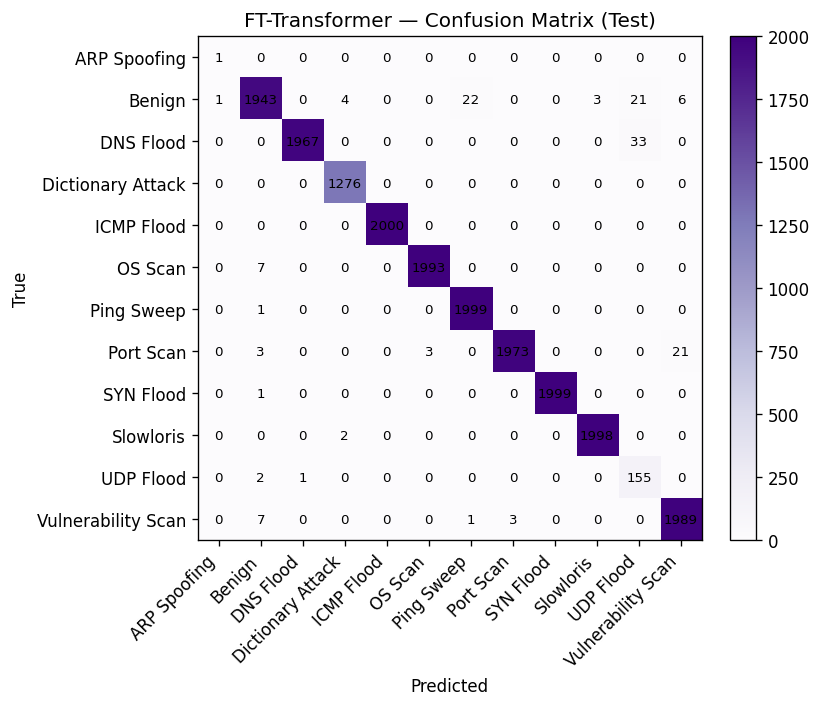

Saved CM: /content/artifacts/ftt_pure/ftt_confusion_matrix.png /content/artifacts/ftt_pure/ftt_confusion_matrix.csv /content/artifacts/ftt_pure/ftt_confusion_matrix_normalized.csv
Saved FT-Transformer bundle to: /content/artifacts/ftt_pure


14329

In [10]:
# @title 🤖 FT-Transformer
import json, numpy as np, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F, joblib, gc
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

train = pd.read_csv(OUT_DIR/"ftt_train.csv")
val   = pd.read_csv(OUT_DIR/"ftt_val.csv")
test  = pd.read_csv(OUT_DIR/"ftt_test.csv")

for c in CAT_COLS + [LABEL_COL]:
    for df_ in (train,val,test):
        if c in df_.columns: df_[c]=df_[c].astype(str)

y_tr = train[LABEL_COL].map(lab2id).to_numpy(); y_va = val[LABEL_COL].map(lab2id).to_numpy(); y_te = test[LABEL_COL].map(lab2id).to_numpy()

# categorical encoders per-column
cat_maps=[]; cat_card=[]
for c in CAT_COLS:
    uniq = pd.Index(train[c].unique().tolist())
    mapping = {v:i+1 for i,v in enumerate(uniq)}  # 0 reserved for unknown
    cat_maps.append(mapping); cat_card.append(len(mapping)+1)

def cats_to_idx(df):
    if not CAT_COLS: return np.zeros((len(df),0),dtype=np.int64)
    mats=[]
    for c,m in zip(CAT_COLS,cat_maps):
        mats.append(df[c].map(m).fillna(0).astype(np.int64).to_numpy().reshape(-1,1))
    return np.concatenate(mats,axis=1)

def nums(df):
    return df[NUM_COLS].to_numpy(dtype=np.float32) if NUM_COLS else np.zeros((len(df),0),dtype=np.float32)

Xtr_num, Xva_num, Xte_num = nums(train), nums(val), nums(test)
Xtr_cat, Xva_cat, Xte_cat = cats_to_idx(train), cats_to_idx(val), cats_to_idx(test)

class TabDS(torch.utils.data.Dataset):
    def __init__(s,Xn,Xc,y): s.Xn=torch.tensor(Xn,dtype=torch.float32); s.Xc=torch.tensor(Xc,dtype=torch.long); s.y=torch.tensor(y,dtype=torch.long)
    def __len__(s): return s.Xn.shape[0]
    def __getitem__(s,i): return s.Xn[i],s.Xc[i],s.y[i]

BATCH, EPOCHS, PATIENCE = 512, 15, 3
tr_loader = torch.utils.data.DataLoader(TabDS(Xtr_num,Xtr_cat,y_tr), batch_size=BATCH, shuffle=True)
va_loader = torch.utils.data.DataLoader(TabDS(Xva_num,Xva_cat,y_va), batch_size=BATCH)
te_loader = torch.utils.data.DataLoader(TabDS(Xte_num,Xte_cat,y_te), batch_size=BATCH)

class FTTransformer(nn.Module):
    def __init__(self,n_num,card,d=16,heads=2,blocks=2,ff=4,drop=0.1,nc=2):
        super().__init__()
        self.n_num=n_num; self.cls=nn.Parameter(torch.zeros(1,1,d))
        if n_num>0:
            self.num_w=nn.Parameter(torch.randn(n_num,d)*0.02); self.num_b=nn.Parameter(torch.zeros(n_num,d))
        else:
            self.register_parameter("num_w",None); self.register_parameter("num_b",None)
        self.emb=nn.ModuleList([nn.Embedding(c,d) for c in card])
        layer=nn.TransformerEncoderLayer(d_model=d,nhead=heads,dim_feedforward=d*ff,dropout=drop,batch_first=True,activation="gelu",norm_first=True)
        self.enc=nn.TransformerEncoder(layer,num_layers=blocks); self.head=nn.Sequential(nn.LayerNorm(d),nn.Linear(d,nc))
    def forward(self,xn,xc):
        B=xn.size(0); toks=[self.cls.expand(B,1,-1)]
        if self.n_num>0: toks.append(xn.unsqueeze(-1)*self.num_w + self.num_b)
        for i,e in enumerate(self.emb): toks.append(e(xc[:,i]).unsqueeze(1))
        x=torch.cat(toks,dim=1); x=self.enc(x); return self.head(x[:,0,:])

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=FTTransformer(len(NUM_COLS),cat_card,nc=len(classes)).to(device)
opt=torch.optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-4); crit=nn.CrossEntropyLoss()

def run(loader,trainflag):
    model.train() if trainflag else model.eval()
    tot, yh, yt=0.0, [], []
    for xn,xc,y in loader:
        xn,xc,y=xn.to(device),xc.to(device),y.to(device)
        if trainflag: opt.zero_grad(set_to_none=True)
        logit=model(xn,xc); loss=crit(logit,y)
        if trainflag: loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(),1.0); opt.step()
        tot+=loss.item()*y.size(0); yh.append(logit.argmax(1).cpu().numpy()); yt.append(y.cpu().numpy())
    yh=np.concatenate(yh); yt=np.concatenate(yt)
    return tot/len(loader.dataset), f1_score(yt,yh,average="macro")

best=float("inf"); wait=0
for ep in range(EPOCHS):
    tr_loss,tr_f1=run(tr_loader,True)
    va_loss,va_f1=run(va_loader,False)
    print(f"Ep{ep:02d} | train {tr_loss:.4f}/{tr_f1:.4f} | val {va_loss:.4f}/{va_f1:.4f}")
    if va_loss<best-1e-4: best=va_loss; wait=0; torch.save(model.state_dict(), ARTIFACTS_DIR/"ftt_pure.pt")
    else:
        wait+=1
        if wait>=PATIENCE: print("Early stop"); break

model.load_state_dict(torch.load(ARTIFACTS_DIR/"ftt_pure.pt", map_location=device))

# ===== Test + Confusion Matrix + Streamlit bundle save =====
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

model.eval()

# --- Predict on test ---
yh, yt = [], []
with torch.no_grad():
    for xn, xc, y in te_loader:
        pred = model(xn.to(device), xc.to(device)).argmax(1).cpu().numpy()
        yh.append(pred); yt.append(y.numpy())
yh = np.concatenate(yh); yt = np.concatenate(yt)

# --- Metrics & report ---
acc = accuracy_score(yt, yh)
mf1 = f1_score(yt, yh, average="macro")
print(f"[FTT] Acc={acc:.4f} | Macro-F1={mf1:.4f}")
print(classification_report(yt, yh, target_names=classes, zero_division=0))

# --- Confusion matrices (counts & row-normalized) ---
cm = confusion_matrix(yt, yh, labels=range(len(classes)))
cm_norm = cm.astype(np.float64) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)

# Prepare save dir (same as Streamlit bundle)
ftt_dir = ARTIFACTS_DIR/"ftt_pure"
ftt_dir.mkdir(parents=True, exist_ok=True)

# Save CSVs
pd.DataFrame(cm, index=classes, columns=classes).to_csv(ftt_dir/"ftt_confusion_matrix.csv")
pd.DataFrame(cm_norm, index=classes, columns=classes).to_csv(ftt_dir/"ftt_confusion_matrix_normalized.csv")

# Plot & save PNG
fig, ax = plt.subplots(figsize=(7.5, 6.0), dpi=120)
im = ax.imshow(cm, cmap="Purples")
ax.set_title("FT-Transformer — Confusion Matrix (Test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right"); ax.set_yticklabels(classes)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=8, color="black")
plt.tight_layout()
png_path = ftt_dir/"ftt_confusion_matrix.png"
plt.savefig(png_path, bbox_inches="tight")
plt.show()
print("Saved CM:", png_path, ftt_dir/"ftt_confusion_matrix.csv", ftt_dir/"ftt_confusion_matrix_normalized.csv")

# --- Streamlit bundle (model + meta + scaler) ---
torch.save(model.state_dict(), ftt_dir/"model.pt")
meta = {
    "label_col": LABEL_COL,
    "classes": classes,
    "cat_cols": CAT_COLS,
    "num_cols": NUM_COLS,
    "cat_maps": [{k: str(v) for k, v in m.items()} for m in cat_maps],
    "cat_cardinalities": cat_card,
    "model_hparams": {"d_token": 16, "n_heads": 2, "n_blocks": 2, "ff_mult": 4,
                      "dropout": 0.1, "n_classes": len(classes)}
}
(ftt_dir/"meta.json").write_text(json.dumps(meta, indent=2))
joblib.dump(joblib.load(OUT_DIR/"ftt_scaler.joblib"), ftt_dir/"ftt_scaler.joblib")

print("Saved FT-Transformer bundle to:", ftt_dir)
del train, val, test; gc.collect()



Ep00 train_loss=0.5877 val_loss=0.1641
Ep01 train_loss=0.1426 val_loss=0.1063
Ep02 train_loss=0.0958 val_loss=0.0882
Ep03 train_loss=0.0767 val_loss=0.0851
Ep04 train_loss=0.0645 val_loss=0.0671
Ep05 train_loss=0.0582 val_loss=0.0539
Ep06 train_loss=0.0491 val_loss=0.0619
Ep07 train_loss=0.0425 val_loss=0.0435
Ep08 train_loss=0.0402 val_loss=0.0389
Ep09 train_loss=0.0387 val_loss=0.0339
Ep10 train_loss=0.0337 val_loss=0.0352
Ep11 train_loss=0.0317 val_loss=0.0325
Ep12 train_loss=0.0293 val_loss=0.0322
Ep13 train_loss=0.0302 val_loss=0.0291
Ep14 train_loss=0.0276 val_loss=0.0322
Ep15 train_loss=0.0266 val_loss=0.0268
Ep16 train_loss=0.0262 val_loss=0.0284
Ep17 train_loss=0.0261 val_loss=0.0315
Ep18 train_loss=0.0259 val_loss=0.0296
Early stop
[MLP] Acc=0.9942 | Macro-F1=0.9861
                    precision    recall  f1-score   support

      ARP Spoofing       1.00      1.00      1.00         1
            Benign       0.99      0.98      0.98      2000
         DNS Flood       1.00   

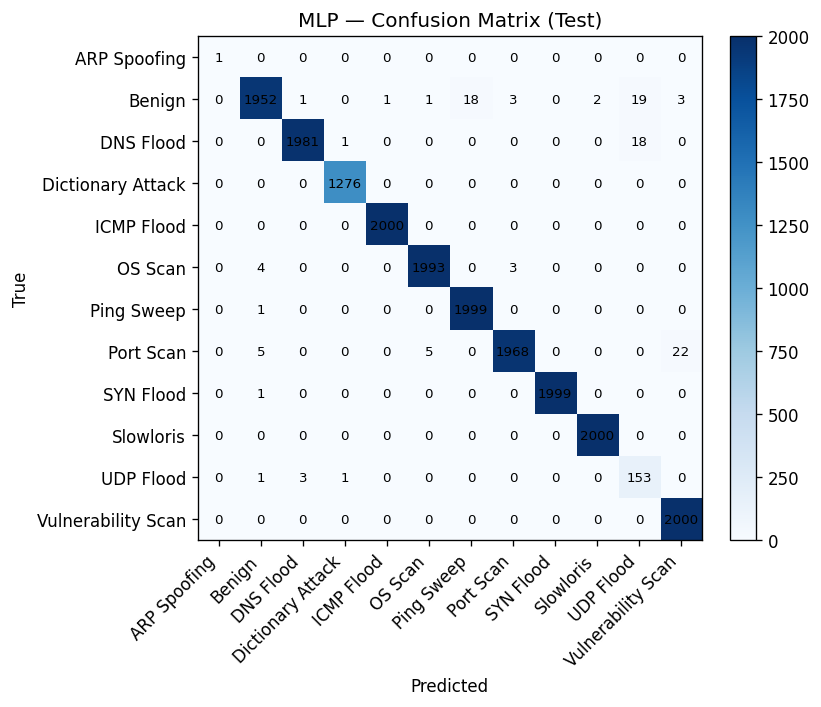

Saved: /content/artifacts/mlp_confusion_matrix.png /content/artifacts/mlp_confusion_matrix.csv /content/artifacts/mlp_confusion_matrix_normalized.csv
Saved MLP to: /content/artifacts/mlp.pt


14300

In [11]:

#@title 🧠 MLP
import json, numpy as np, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F, joblib, gc
from sklearn.metrics import accuracy_score, f1_score, classification_report

# load splits & shared encoder
train = pd.read_csv(OUT_DIR/"ftt_train.csv")
val   = pd.read_csv(OUT_DIR/"ftt_val.csv")
test  = pd.read_csv(OUT_DIR/"ftt_test.csv")
classes = json.loads((ARTIFACTS_DIR/"classes.json").read_text()) if (ARTIFACTS_DIR/"classes.json").exists() else sorted(train[LABEL_COL].unique().tolist())
lab2id = {c:i for i,c in enumerate(classes)}
ytr = train[LABEL_COL].map(lab2id).to_numpy(); yva = val[LABEL_COL].map(lab2id).to_numpy(); yte = test[LABEL_COL].map(lab2id).to_numpy()

ohe = joblib.load(ARTIFACTS_DIR/"ohe.joblib") if (ARTIFACTS_DIR/"ohe.joblib").exists() else None
if ohe is None:
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    bundle = joblib.load(OUT_DIR/"ftt_scaler.joblib")
    CAT_COLS = bundle["cat_cols"] or []; NUM_COLS = bundle["num_cols"] or []
    try:
        ohe = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32), CAT_COLS),
                                 ("pass","passthrough",NUM_COLS)])
    except TypeError:
        ohe = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False, dtype=np.float32), CAT_COLS),
                                 ("pass","passthrough",NUM_COLS)])
    Xtr = ohe.fit_transform(train[CAT_COLS+NUM_COLS])
    Xva = ohe.transform(val[CAT_COLS+NUM_COLS]); Xte = ohe.transform(test[CAT_COLS+NUM_COLS])
    joblib.dump(ohe, ARTIFACTS_DIR/"ohe.joblib")
else:
    # derive feature order from ohe
    cat_cols = list(ohe.transformers_[0][2]); num_cols = list(ohe.transformers_[1][2])
    Xtr = ohe.transform(train[cat_cols+num_cols]); Xva = ohe.transform(val[cat_cols+num_cols]); Xte = ohe.transform(test[cat_cols+num_cols])

input_dim = Xtr.shape[1]; n_classes = len(classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self, d_in, d_hidden=512, drop=0.2, n_out=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(d_hidden, d_hidden//2), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(d_hidden//2, n_out)
        )
    def forward(self, x): return self.net(x)

def to_loader(X,y,batch=512,shuffle=False):
    ds = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
    return torch.utils.data.DataLoader(ds, batch_size=batch, shuffle=shuffle)

tr_loader = to_loader(Xtr,ytr,batch=512,shuffle=True); va_loader = to_loader(Xva,yva,batch=512); te_loader = to_loader(Xte,yte,batch=512)

model = MLP(input_dim, d_hidden=512, drop=0.2, n_out=n_classes).to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
crit  = nn.CrossEntropyLoss()

best=float("inf"); wait=0
for ep in range(20):
    model.train(); tl=0.0
    for xb,yb in tr_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        loss = crit(model(xb), yb); loss.backward(); opt.step()
        tl += loss.item()*yb.size(0)
    tl /= len(tr_loader.dataset)

    model.eval(); vl=0.0
    with torch.no_grad():
        for xb,yb in va_loader:
            xb,yb=xb.to(device),yb.to(device)
            vl += crit(model(xb), yb).item()*yb.size(0)
    vl/=len(va_loader.dataset)
    print(f"Ep{ep:02d} train_loss={tl:.4f} val_loss={vl:.4f}")
    if vl<best-1e-4: best=vl; wait=0; torch.save(model.state_dict(), ARTIFACTS_DIR/"mlp.pt")
    else:
        wait+=1
        if wait>=3: print("Early stop"); break

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

model.load_state_dict(torch.load(ARTIFACTS_DIR/"mlp.pt", map_location=device))
model.eval()

# --- Predict on test ---
preds, gts = [], []
with torch.no_grad():
    for xb, yb in te_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds.append(logits.argmax(1).cpu().numpy())
        gts.append(yb.numpy())

yp = np.concatenate(preds)
yt = np.concatenate(gts)

# --- Metrics ---
acc = accuracy_score(yt, yp)
mf1 = f1_score(yt, yp, average='macro')
print(f"[MLP] Acc={acc:.4f} | Macro-F1={mf1:.4f}")
print(classification_report(yt, yp, target_names=classes, zero_division=0))

# --- Confusion Matrix (counts & normalized) ---
cm = confusion_matrix(yt, yp, labels=range(len(classes)))
cm_norm = cm.astype(np.float64) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)

# Save CSVs
import pandas as pd
pd.DataFrame(cm, index=classes, columns=classes).to_csv(ARTIFACTS_DIR/"mlp_confusion_matrix.csv")
pd.DataFrame(cm_norm, index=classes, columns=classes).to_csv(ARTIFACTS_DIR/"mlp_confusion_matrix_normalized.csv")

# Plot & save PNG
fig, ax = plt.subplots(figsize=(7.5, 6.0), dpi=120)
im = ax.imshow(cm, cmap="Blues")
ax.set_title("MLP — Confusion Matrix (Test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=8, color="black")

plt.tight_layout()
cm_path = ARTIFACTS_DIR/"mlp_confusion_matrix.png"
plt.savefig(cm_path, bbox_inches="tight")
plt.show()
print("Saved:", cm_path, ARTIFACTS_DIR/"mlp_confusion_matrix.csv", ARTIFACTS_DIR/"mlp_confusion_matrix_normalized.csv")

# --- Save meta (unchanged) ---
(ARTIFACTS_DIR/"classes.json").write_text(json.dumps(classes, indent=2))  # (overwrite ok)
(ARTIFACTS_DIR/"mlp_meta.json").write_text(json.dumps({"input_dim": int(input_dim)}, indent=2))
print("Saved MLP to:", ARTIFACTS_DIR/"mlp.pt")

# cleanup
del train, val, test; gc.collect()


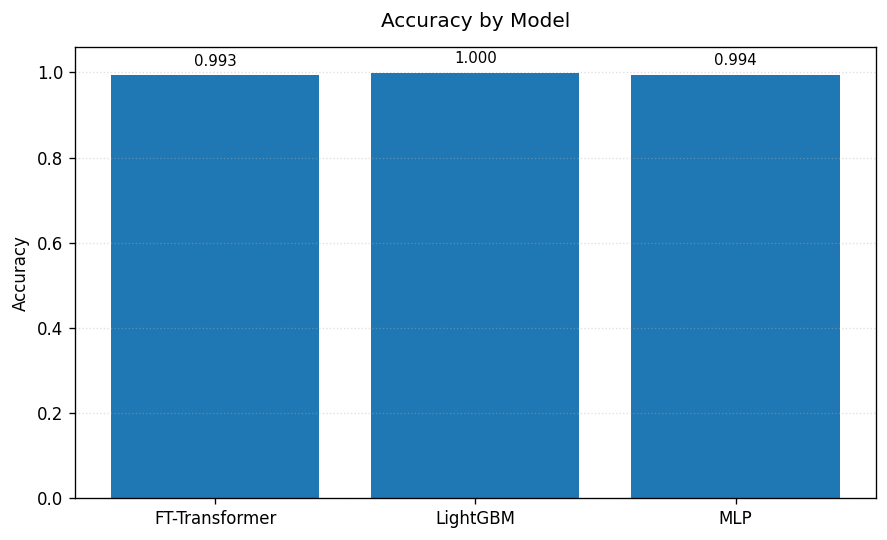

Saved: /content/artifacts/perf_accuracy_by_model.png


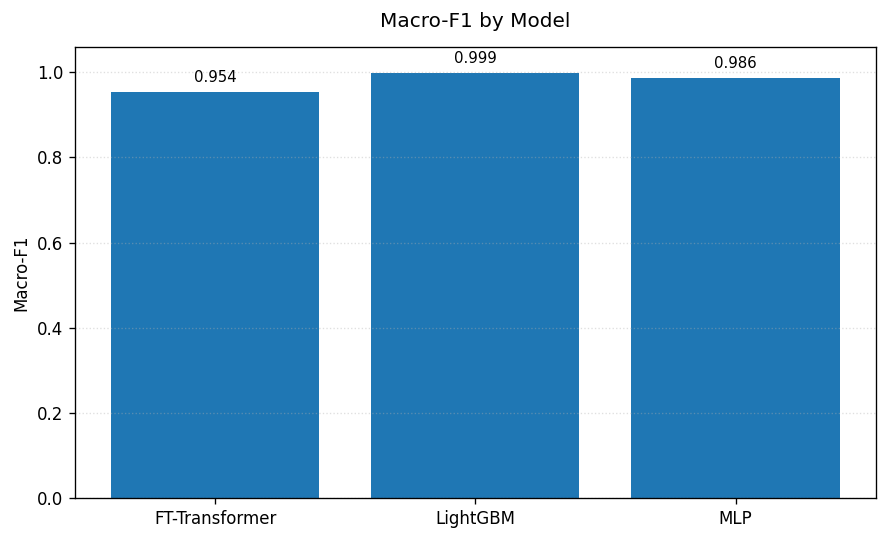

Saved: /content/artifacts/perf_macrof1_by_model.png


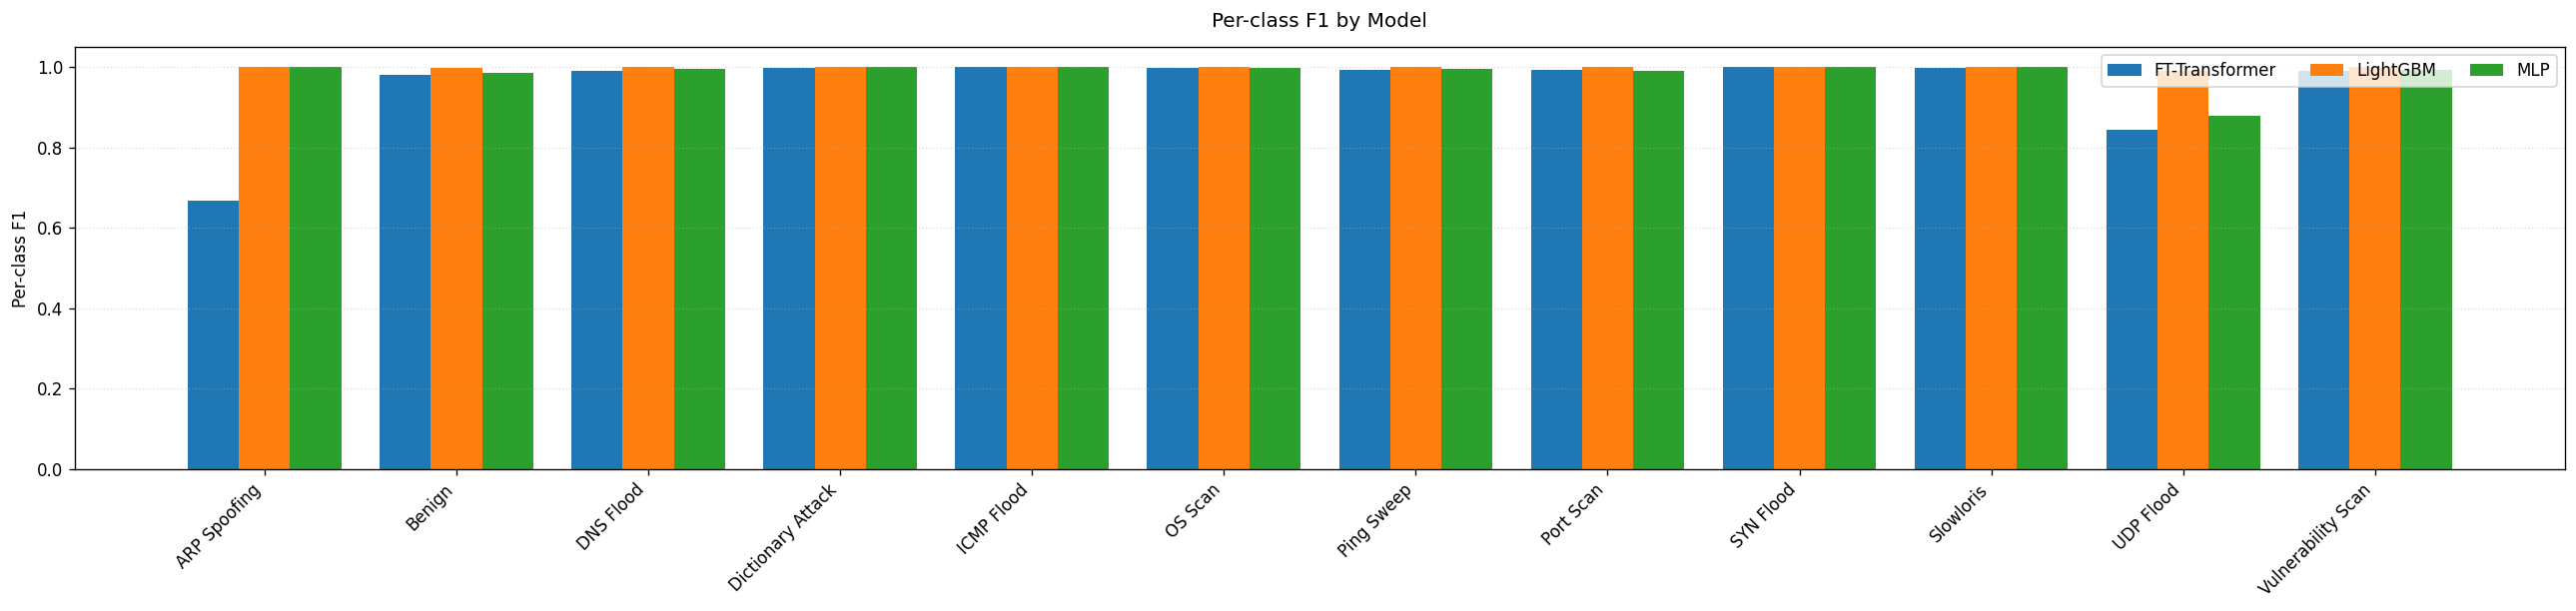

Saved: /content/artifacts/perf_perclass_f1_grouped.png


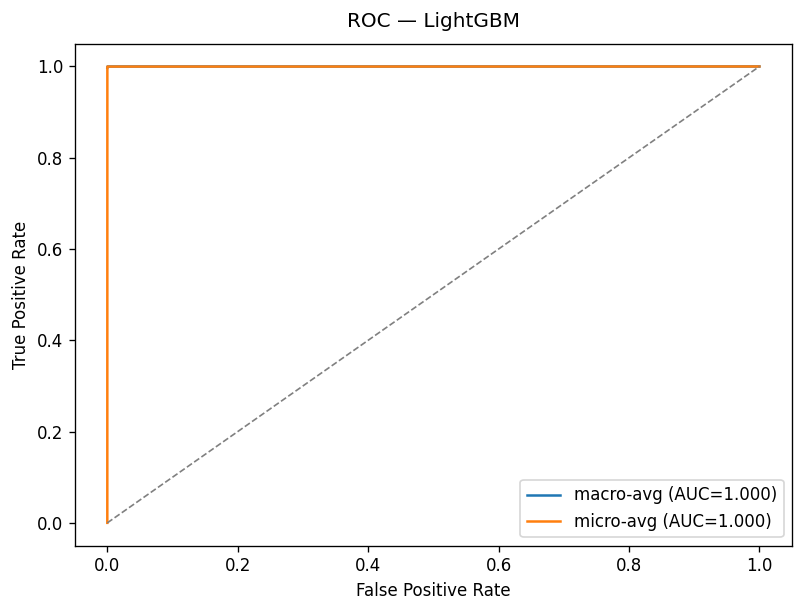

Saved: /content/artifacts/roc_lightgbm.png


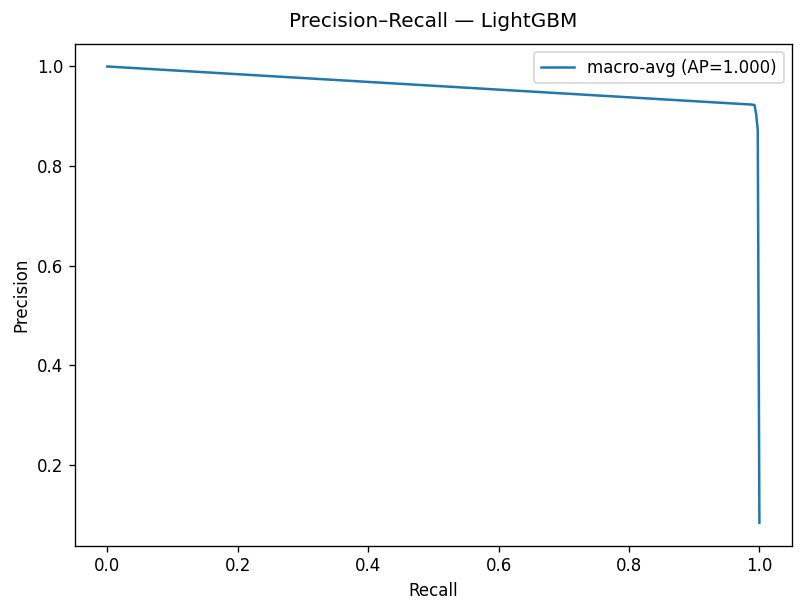

Saved: /content/artifacts/pr_lightgbm.png


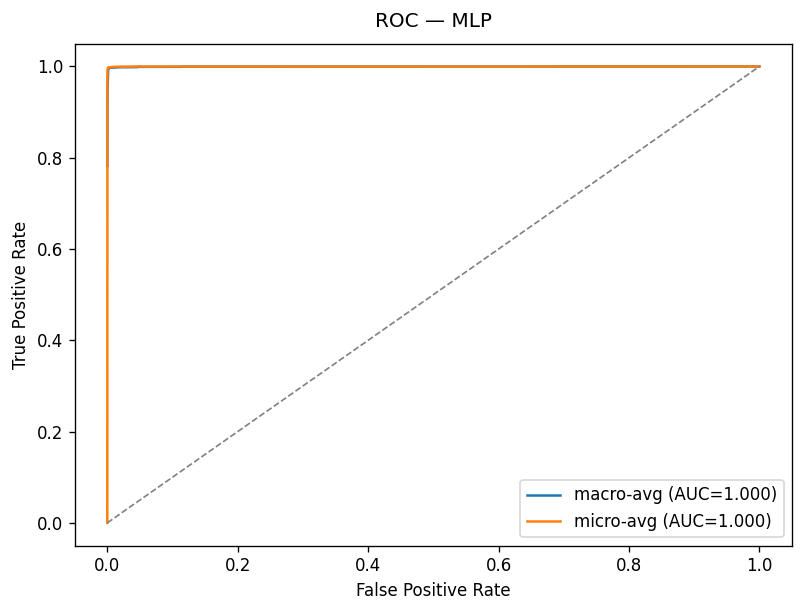

Saved: /content/artifacts/roc_mlp.png


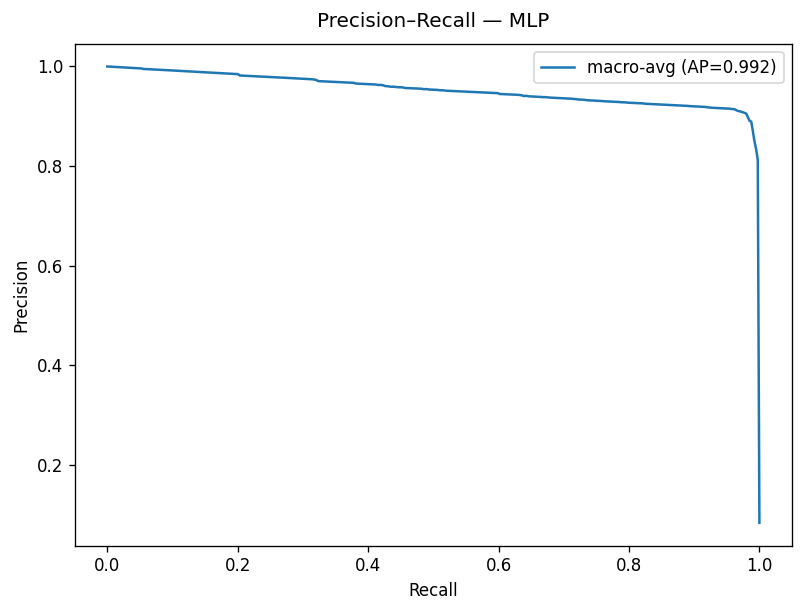

Saved: /content/artifacts/pr_mlp.png


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



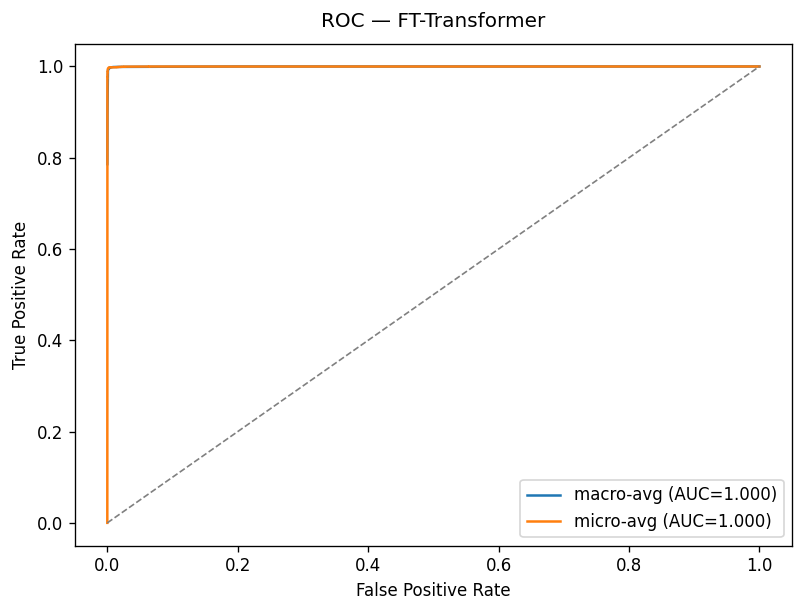

Saved: /content/artifacts/roc_ft_transformer.png


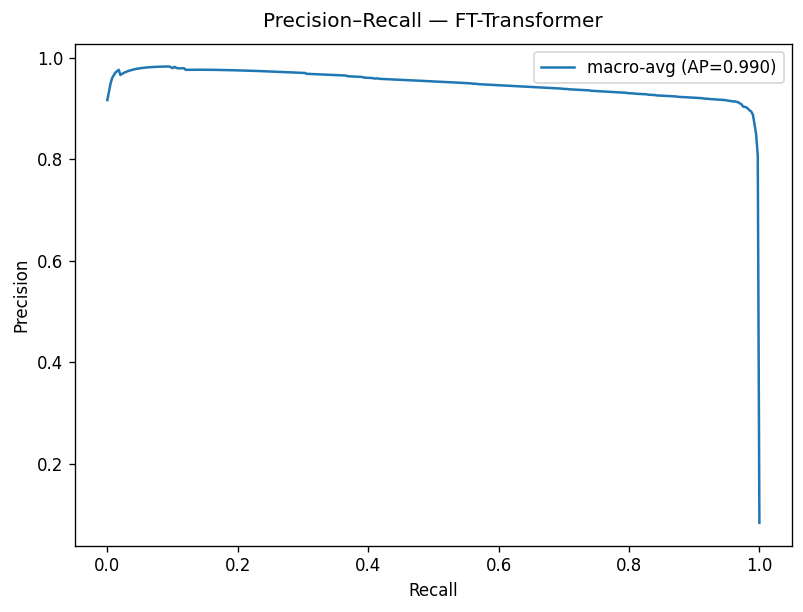

Saved: /content/artifacts/pr_ft_transformer.png
Saved tables: /content/artifacts/perf_summary_models.csv /content/artifacts/perf_perclass_f1_table.csv


In [13]:
# ============================================================
# 📊 Performance Dashboard + ROC & PR (LGBM / FTT / MLP)
# - Fixes overlapping labels in bar charts
# - Loads CM CSVs for summary charts
# - Loads or computes per-sample probabilities for ROC/PR
# ============================================================
from pathlib import Path
import json, gc, numpy as np, pandas as pd, joblib, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

ARTIFACTS_DIR = Path(ARTIFACTS_DIR)
OUT_DIR = Path(OUT_DIR)

# ---- Expected files
CM_FILES = {
    "LightGBM": ARTIFACTS_DIR / "lgbm_confusion_matrix.csv",
    "FT-Transformer": ARTIFACTS_DIR / "ftt_pure" / "ftt_confusion_matrix.csv",
    "MLP": ARTIFACTS_DIR / "mlp_confusion_matrix.csv",
}

PROBA_FILES = {
    "LightGBM": ARTIFACTS_DIR / "lgbm_proba.npy",
    "FT-Transformer": ARTIFACTS_DIR / "ftt_pure" / "ftt_proba.npy",
    "MLP": ARTIFACTS_DIR / "mlp_proba.npy",
}

# ---- Classes
cls_path = ARTIFACTS_DIR / "classes.json"
if cls_path.exists():
    classes = json.loads(cls_path.read_text())
else:
    # infer from any CM
    for p in CM_FILES.values():
        if p.exists():
            classes = pd.read_csv(p, index_col=0).index.tolist()
            break
    else:
        # last fallback (optional)
        labmap = OUT_DIR / "label_mapping.json"
        if labmap.exists():
            classes = list(json.loads(labmap.read_text()).keys())
        else:
            raise FileNotFoundError("Cannot determine classes. Provide classes.json or a confusion_matrix.csv.")

n_classes = len(classes)
cls2id = {c:i for i,c in enumerate(classes)}

# ---- Helper: metrics from CM
def metrics_from_cm(cm: np.ndarray, classes: list[str]):
    cm = np.asarray(cm, dtype=np.int64)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    with np.errstate(divide="ignore", invalid="ignore"):
        prec = np.where(tp+fp>0, tp/(tp+fp), 0.0)
        rec  = np.where(tp+fn>0, tp/(tp+fn), 0.0)
        f1   = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0.0)
    acc = tp.sum()/cm.sum() if cm.sum()>0 else 0.0
    macro_f1 = float(np.mean(f1)) if len(f1) else 0.0
    return acc, macro_f1, {classes[i]: float(f1[i]) for i in range(len(classes))}

# ---- Load CM & build summary tables
summary_rows=[]; per_class_rows=[]; available=[]
for name, path in CM_FILES.items():
    if not path.exists():
        print(f"[WARN] {name} confusion_matrix not found at {path}. Skipping in bar charts.")
        continue
    df = pd.read_csv(path, index_col=0)
    if list(df.index)!=classes:
        df = df.reindex(index=classes, columns=classes, fill_value=0)
    cm = df.values
    acc, macro_f1, pc = metrics_from_cm(cm, classes)
    summary_rows.append({"model":name, "accuracy":acc, "macro_f1":macro_f1})
    for c in classes:
        per_class_rows.append({"model":name,"class":c,"f1":pc[c]})
    available.append(name)

if not summary_rows:
    raise RuntimeError("No confusion matrices found for any model.")

summary_df = pd.DataFrame(summary_rows).set_index("model").sort_index()
per_class_df = pd.DataFrame(per_class_rows)

# ---- NICE bars (fix overlap): use bar_label + headroom
def plot_bars(values: pd.Series, title: str, ylabel: str, outfile: Path):
    fig, ax = plt.subplots(figsize=(7.5, 4.6), dpi=120)
    bars = ax.bar(values.index, values.values)
    # Headroom for labels
    ymax = max(1.0, values.values.max() + 0.06)
    ax.set_ylim(0, ymax)
    ax.set_ylabel(ylabel)
    ax.set_title(title, pad=12)
    ax.grid(axis='y', linestyle=':', alpha=0.4)
    # value labels centered on top of bars
    ax.bar_label(bars, labels=[f"{v:.3f}" for v in values.values], padding=4, fontsize=9)
    plt.tight_layout()
    plt.savefig(outfile, bbox_inches="tight")
    plt.show()
    print("Saved:", outfile)

plot_bars(summary_df["accuracy"], "Accuracy by Model", "Accuracy", ARTIFACTS_DIR/"perf_accuracy_by_model.png")
plot_bars(summary_df["macro_f1"], "Macro-F1 by Model", "Macro-F1", ARTIFACTS_DIR/"perf_macrof1_by_model.png")

# ---- Per-class F1 grouped bars
pivot = per_class_df.pivot(index="class", columns="model", values="f1").reindex(index=classes)
fig, ax = plt.subplots(figsize=(max(9, 0.6*len(classes)*max(1,len(available))), 5.2), dpi=120)
x = np.arange(len(classes))
width = 0.8 / max(len(available), 1)
for i, m in enumerate(sorted(available)):
    vals = pivot[m].fillna(0.0).to_numpy()
    ax.bar(x + i*width - (len(available)-1)*width/2, vals, width, label=m)
ax.set_xticks(x); ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_ylim(0, 1.05); ax.set_ylabel("Per-class F1"); ax.set_title("Per-class F1 by Model", pad=12)
ax.legend(ncols=min(len(available),3))
ax.grid(axis='y', linestyle=':', alpha=0.4)
plt.tight_layout()
out_pc = ARTIFACTS_DIR/"perf_perclass_f1_grouped.png"
plt.savefig(out_pc, bbox_inches="tight"); plt.show()
print("Saved:", out_pc)

# ---- ROC/PR: load or compute probabilities
def load_or_compute_proba(model_name: str):
    # If pre-saved, load and return (n_samples, n_classes), and y_true
    if PROBA_FILES[model_name].exists() and (OUT_DIR/"ftt_test.csv").exists():
        proba = np.load(PROBA_FILES[model_name])
        y_true = pd.read_csv(OUT_DIR/"ftt_test.csv")[LABEL_COL].astype(str).map(cls2id).to_numpy()
        return proba, y_true

    # Else recompute from artifacts
    test = pd.read_csv(OUT_DIR/"ftt_test.csv")
    y_true = test[LABEL_COL].astype(str).map(cls2id).to_numpy()

    if model_name == "LightGBM":
        import lightgbm as lgb
        ohe = joblib.load(ARTIFACTS_DIR/"ohe.joblib")
        Xte = ohe.transform(test[list(ohe.transformers_[0][2])+list(ohe.transformers_[1][2])])
        booster = lgb.Booster(model_file=str(ARTIFACTS_DIR/"lgbm_model.txt"))
        proba = booster.predict(Xte)
        np.save(PROBA_FILES["LightGBM"], proba)

    elif model_name == "MLP":
        import torch, torch.nn as nn
        device = "cuda" if (hasattr(torch, "cuda") and torch.cuda.is_available()) else "cpu"
        ohe = joblib.load(ARTIFACTS_DIR/"ohe.joblib")
        Xte = ohe.transform(test[list(ohe.transformers_[0][2])+list(ohe.transformers_[1][2])])
        class MLP(nn.Module):
            def __init__(self, d_in, d_hidden=512, drop=0.2, n_out=n_classes):
                super().__init__()
                self.net = nn.Sequential(
                    nn.Linear(d_in, d_hidden), nn.ReLU(), nn.Dropout(drop),
                    nn.Linear(d_hidden, d_hidden//2), nn.ReLU(), nn.Dropout(drop),
                    nn.Linear(d_hidden//2, n_out)
                )
            def forward(self, x): return self.net(x)
        meta = json.loads((ARTIFACTS_DIR/"mlp_meta.json").read_text())
        model = MLP(meta["input_dim"], n_out=n_classes).to(device)
        model.load_state_dict(torch.load(ARTIFACTS_DIR/"mlp.pt", map_location=device))
        model.eval()
        proba = []
        with torch.no_grad():
            X = torch.tensor(Xte, dtype=torch.float32, device=device)
            logits = model(X)
            proba = torch.softmax(logits, dim=1).cpu().numpy()
        np.save(PROBA_FILES["MLP"], proba)

    elif model_name == "FT-Transformer":
        import torch, torch.nn as nn
        device = "cuda" if (hasattr(torch, "cuda") and torch.cuda.is_available()) else "cpu"
        meta = json.loads((ARTIFACTS_DIR/"ftt_pure"/"meta.json").read_text())
        CAT = meta["cat_cols"]; NUM = meta["num_cols"]; maps = meta["cat_maps"]; card = meta["cat_cardinalities"]
        # Build cats
        def cats_to_idx(df):
            if not CAT: return np.zeros((len(df),0), dtype=np.int64)
            mats=[]
            for c,m in zip(CAT, maps):
                m_i = {k:int(v) for k,v in m.items()}
                mats.append(df[c].astype(str).map(m_i).fillna(0).astype(np.int64).to_numpy().reshape(-1,1))
            return np.concatenate(mats, axis=1)
        def nums(df):
            return df[NUM].to_numpy(dtype=np.float32) if NUM else np.zeros((len(df),0), dtype=np.float32)
        Xte_num = nums(test); Xte_cat = cats_to_idx(test)
        class FTT(nn.Module):
            def __init__(self,n_num,card,d=meta["model_hparams"]["d_token"],
                         heads=meta["model_hparams"]["n_heads"],
                         blocks=meta["model_hparams"]["n_blocks"],
                         ff=meta["model_hparams"]["ff_mult"],
                         drop=meta["model_hparams"]["dropout"], n_out=n_classes):
                super().__init__()
                self.n_num=n_num; self.cls=nn.Parameter(torch.zeros(1,1,d))
                if n_num>0:
                    self.num_w=nn.Parameter(torch.randn(n_num,d)*0.02); self.num_b=nn.Parameter(torch.zeros(n_num,d))
                else:
                    self.register_parameter("num_w",None); self.register_parameter("num_b",None)
                self.emb=nn.ModuleList([nn.Embedding(c,d) for c in card])
                layer=nn.TransformerEncoderLayer(d_model=d,nhead=heads,dim_feedforward=d*ff,dropout=drop,batch_first=True,activation="gelu",norm_first=True)
                self.enc=nn.TransformerEncoder(layer,num_layers=blocks); self.head=nn.Sequential(nn.LayerNorm(d),nn.Linear(d,n_out))
            def forward(self,xn,xc):
                B=xn.size(0); toks=[self.cls.expand(B,1,-1)]
                if self.n_num>0: toks.append(xn.unsqueeze(-1)*self.num_w + self.num_b)
                for i,e in enumerate(self.emb): toks.append(e(xc[:,i]).unsqueeze(1))
                x=torch.cat(toks,dim=1); x=self.enc(x); return self.head(x[:,0,:])
        model = FTT(len(NUM), card).to(device)
        model.load_state_dict(torch.load(ARTIFACTS_DIR/"ftt_pure"/"model.pt", map_location=device))
        model.eval()
        with torch.no_grad():
            xn = torch.tensor(Xte_num, dtype=torch.float32, device=device)
            xc = torch.tensor(Xte_cat, dtype=torch.long, device=device)
            logits = model(xn, xc)
            proba = torch.softmax(logits, dim=1).cpu().numpy()
        np.save(PROBA_FILES["FT-Transformer"], proba)

    else:
        raise ValueError(model_name)

    gc.collect()
    return proba, y_true

# ---- Build ROC & PR plots
def plot_roc_pr(model_name: str):
    # get proba and y
    try:
        proba, y_true = load_or_compute_proba(model_name)
    except Exception as e:
        print(f"[WARN] Could not get probabilities for {model_name}: {e}")
        return
    if proba is None:
        print(f"[WARN] No probabilities for {model_name}.")
        return

    # binarize labels
    Y = label_binarize(y_true, classes=list(range(n_classes)))
    # ROC (macro + micro)
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y[:, i], proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= max(n_classes,1)
    macro_auc = auc(all_fpr, mean_tpr)

    # micro-average
    fpr_micro, tpr_micro, _ = roc_curve(Y.ravel(), proba.ravel())
    micro_auc = auc(fpr_micro, tpr_micro)

    fig, ax = plt.subplots(figsize=(6.8, 5.2), dpi=120)
    ax.plot(all_fpr, mean_tpr, label=f"macro-avg (AUC={macro_auc:.3f})")
    ax.plot(fpr_micro, tpr_micro, label=f"micro-avg (AUC={micro_auc:.3f})")
    ax.plot([0,1],[0,1],"--", lw=1, color="gray")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC — {model_name}", pad=10); ax.legend()
    plt.tight_layout()
    out = ARTIFACTS_DIR / f"roc_{model_name.lower().replace('-','_')}.png"
    plt.savefig(out, bbox_inches="tight"); plt.show()
    print("Saved:", out)

    # PR (macro)
    precisions=[]; recalls=[]; ap_scores=[]
    for i in range(n_classes):
        pr, rc, _ = precision_recall_curve(Y[:, i], proba[:, i])
        precisions.append(pr); recalls.append(rc)
        ap_scores.append(average_precision_score(Y[:, i], proba[:, i]))
    # interpolate PR to mean curve length (rough macro plot)
    grid = np.linspace(0,1,400)
    interp = []
    for pr, rc in zip(precisions, recalls):
        # invert rc to monotonic increasing grid for interpolation
        order = np.argsort(rc)
        interp.append(np.interp(grid, rc[order], pr[order]))
    mean_pr = np.mean(interp, axis=0)
    macro_ap = np.mean(ap_scores)

    fig, ax = plt.subplots(figsize=(6.8, 5.2), dpi=120)
    ax.plot(grid, mean_pr, label=f"macro-avg (AP={macro_ap:.3f})")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_title(f"Precision–Recall — {model_name}", pad=10); ax.legend()
    plt.tight_layout()
    out = ARTIFACTS_DIR / f"pr_{model_name.lower().replace('-','_')}.png"
    plt.savefig(out, bbox_inches="tight"); plt.show()
    print("Saved:", out)

# Generate ROC/PR for models we have (skip if CM missing AND cannot compute)
for name in ["LightGBM", "MLP", "FT-Transformer"]:
    plot_roc_pr(name)

# Save numeric summaries too
summary_df.to_csv(ARTIFACTS_DIR/"perf_summary_models.csv")
per_class_df.pivot(index="class", columns="model", values="f1").to_csv(ARTIFACTS_DIR/"perf_perclass_f1_table.csv")
print("Saved tables:",
      ARTIFACTS_DIR/"perf_summary_models.csv",
      ARTIFACTS_DIR/"perf_perclass_f1_table.csv")
